In [1]:
%matplotlib inline
%pylab inline

from functools import partial

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift

from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph

from menpofit.result import compute_normalise_point_to_point_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutAsymmetricGaussNewton,
    SSDAsymmetricGaussNewtonSimultaneous)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

## Load AAM

In [3]:
aam = mio.import_pickle('/Users/joan/PhD/Results/alabort_aam_2015/aam.pkl.gz')

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/Users/joan/PhD/DataBases/faces/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


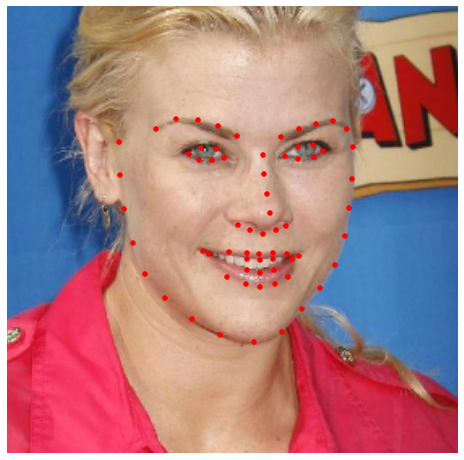

In [5]:
visualize_images(test_images)

## Fit AAM

In [6]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [12, 8]
scale = 0.25
noise_percentage = 0.04

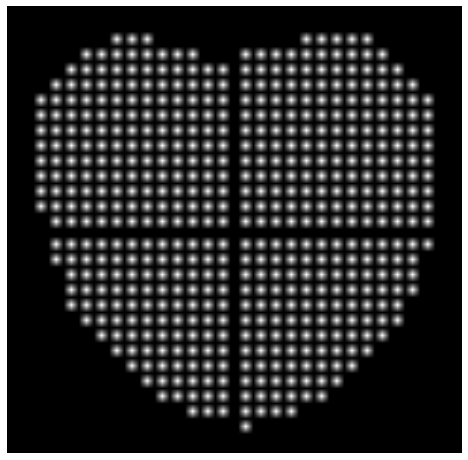

In [7]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

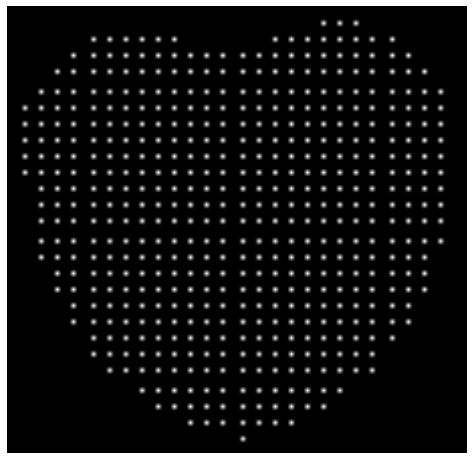

In [8]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [9]:
sampling_step = [sampling_step_1, sampling_step_2]

#### Sampled AAM Fitter

In [10]:
fitter_0 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(ProjectOutAsymmetricGaussNewton), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=partial(SSDAsymmetricGaussNewtonSimultaneous), 
    n_shape=n_shape, 
    n_appearance=n_appearance,
    sampling=sampling_step)

In [38]:
am_0 = fitter_0.aam.appearance_models[0]
am_1 = fitter_0.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

1st scale -> 	variance: 0.750517836986 	components: 225
2nd scale -> 	variance: 0.75026814791 	components: 280


In [11]:
alphas = np.arange(0, 1.1, 0.1)
n_fitters = len(alphas)
legend_entries = ['ini'] + [str(alpha) for alpha in alphas]

#### Fitter 0 fitting loop

In [12]:
fitters_results_0 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitter_0.noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage)

    for alpha in alphas:
        
        fr = fitter_0.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=alpha) 
        fr.downscale = 0.5
        fitters_results_0.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitter 1 fitting loop

In [13]:
fitters_results_1 = []
for j, image in enumerate(test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitter_1.noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage)

    for alpha in alphas:
        
        fr = fitter_1.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters, alpha=alpha) 
        fr.downscale = 0.5
        fitters_results_1.append(fr)
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Visualize Results

Produce combined mean error vs alpha graph:

In [14]:
fitters_results = [fitters_results_0,
                   fitters_results_1]

In [15]:
mean_errors = []
std_errors = []
median_errors = []

for frs in fitters_results:

    errors = []
    for j in range(n_fitters):
        errors_j = []
        for fr in frs[j::n_fitters]:
            error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                           fr.gt_shape.points[17:, :],
                                                           norm_shape=fr.gt_shape.points)
            errors_j.append(error)
        errors.append(errors_j)

    mean_errs = []
    std_errs = []
    median_errs = []
    for j in range(n_fitters):
        errs = np.asarray(errors[j])
        mean_errs.append(np.mean(errs))
        std_errs.append(np.std(errs))
        median_errs.append(np.median(errs))
    
    mean_errors.append(mean_errs)
    std_errors.append(std_errs)
    median_errors.append(median_errs)
    
mean_errors_matrix = np.asarray(mean_errors).T
std_errors_matrix = np.asarray(std_errors).T
median_errors_matrix = np.asarray(median_errors).T

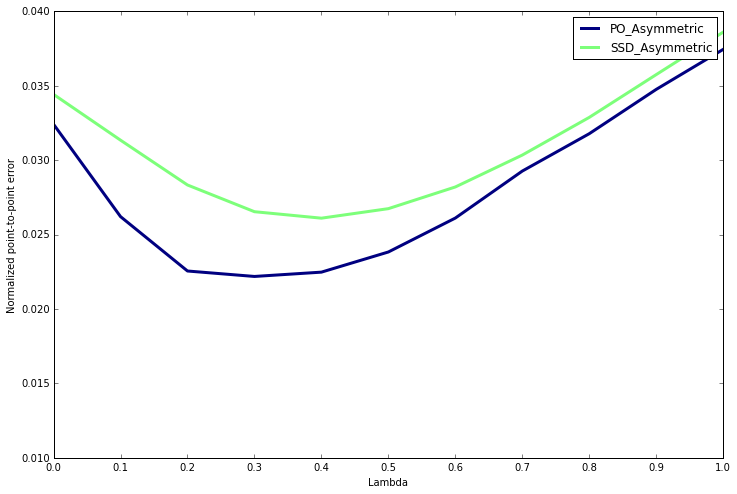

In [16]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(2, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(mean_errors_matrix.shape[1]):
    plt.plot(np.arange(0, len(mean_errors_matrix[:, i])), 
             mean_errors_matrix[:, i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Lambda')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, 1))
plt.ylim((0.01, 0.04))

width = mean_errors_matrix.shape[0]
x_axis_labels = legend_entries[1:]
plt.xticks(range(width), x_axis_labels[:width])

plt.legend(['PO_Asymmetric', 'SSD_Asymmetric'])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/mean_error_vs_alpha_0.04.png', 
            format='png', dpi=300)

For a particular algorithm: 

1) visualize fitting results:

In [28]:
fitters_results = fitters_results_0

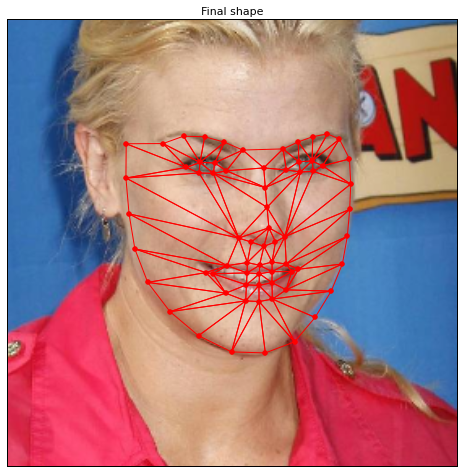

In [29]:
visualize_fitting_result(fitters_results)

2) Produce CED graph:

In [30]:
errors = [[]]
for fr in fitters_results[::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)

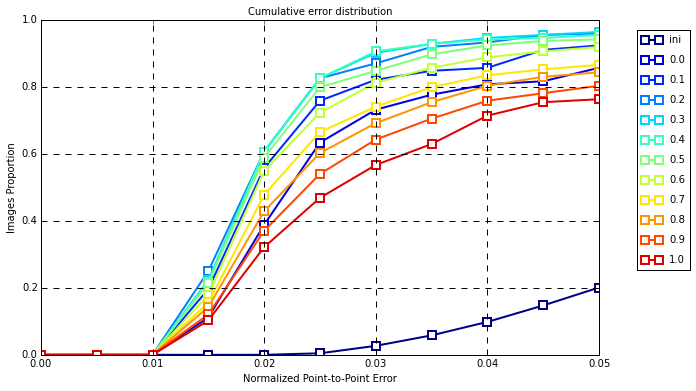

In [31]:
plot_ced(errors, legend_entries=legend_entries)

3) Produce fitting statistics:

In [32]:
for j, e in enumerate(errors):
    print legend_entries[j], '\tmean:{0:.4f}'.format(np.mean(e)), '\tstd:{0:.4f}'.format(np.std(e)), '\tmedian:{0:.4f}'.format(np.median(e))

ini 	mean:0.0735 	std:0.0264 	median:0.0718
0.0 	mean:0.0324 	std:0.0316 	median:0.0223
0.1 	mean:0.0262 	std:0.0244 	median:0.0192
0.2 	mean:0.0226 	std:0.0166 	median:0.0185
0.3 	mean:0.0222 	std:0.0164 	median:0.0184
0.4 	mean:0.0225 	std:0.0172 	median:0.0181
0.5 	mean:0.0238 	std:0.0185 	median:0.0191
0.6 	mean:0.0261 	std:0.0207 	median:0.0196
0.7 	mean:0.0293 	std:0.0238 	median:0.0202
0.8 	mean:0.0318 	std:0.0256 	median:0.0214
0.9 	mean:0.0348 	std:0.0270 	median:0.0239
1.0 	mean:0.0374 	std:0.0280 	median:0.0264


4) Produce mean and median error convergence graphs:

In [22]:
mean_errors = []
std_errors = []
median_errors = []
for j in range(n_fitters):
    errors = []
    for fr in fitters_results[j::n_fitters]:
        errs = []
        for shape in fr.shapes:
            err = compute_normalise_point_to_point_error(shape.points[17:, :], 
                                                         fr.gt_shape.points[17:, :],
                                                          norm_shape=fr.gt_shape.points)
            errs.append(err)
        errors.append(errs)
    mean_errors.append(np.mean(errors, axis=0))
    std_errors.append(np.std(errors, axis=0))
    median_errors.append(np.median(errors, axis=0))

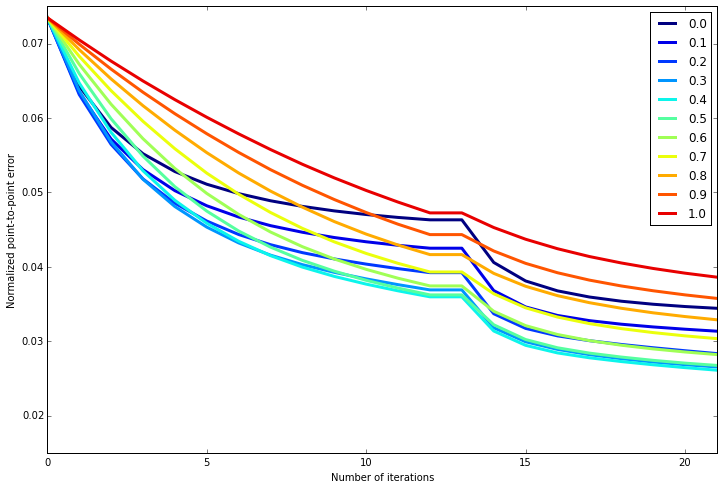

In [23]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             mean_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/mean_error_vs_iters_alpha_po_0.04.png', 
            format='png', dpi=300)

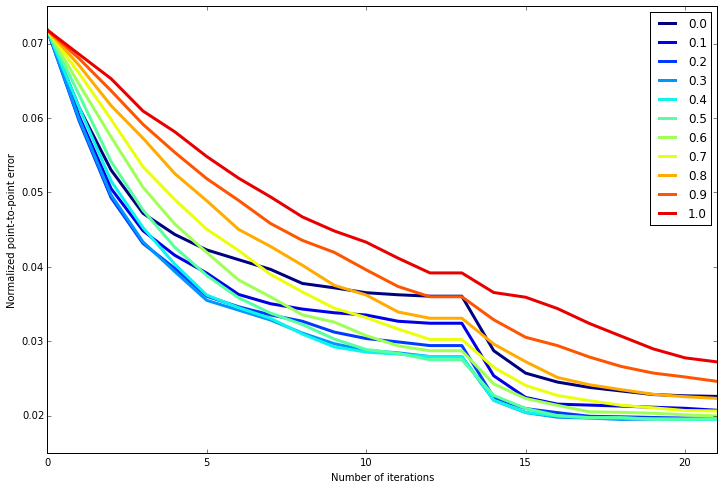

In [24]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(n_fitters, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(len(mean_errors)):
    plt.plot(np.arange(0, len(mean_errors[i])),
             median_errors[i],
             color=colours[i],
             linewidth=3)
    
plt.xlabel('Number of iterations')
plt.ylabel('Normalized point-to-point error')
plt.xlim((0, len(mean_errors[i]) - 1))
plt.ylim((0.015, 0.075))
plt.legend(legend_entries[1:])

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig('/Users/joan/PhD/Results/alabort_aam_2015/median_error_vs_iters_alpha_po_0.04.png', 
            format='png', dpi=300)

## Other

In [25]:
# import  matplotlib.pyplot as plt
# from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

# colours = sample_colours_from_colourmap(n_fitters, 'jet')

# fig = plt.figure()
# plt.hold(True)

# for i in range(len(mean_errors)):
#     plt.errorbar(np.arange(0, len(mean_errors[i])), 
#                  mean_errors[i], 
#                  yerr=0.1 * std_errors[i],
#                  color=colours[i],
#                  marker='o',
#                  markersize=10,
#                  linewidth=1.5)
#     plt.fill_between(np.arange(0, len(mean_errors[i])), 
#                      mean_errors[i] - 0.1 * std_errors[i], 
#                      mean_errors[i] + 0.1 * std_errors[i],
#                      color=colours[i],
#                      alpha=0.1)
#     plt.plot(np.arange(0, len(mean_errors[i])),
#              median_errors[i],
#              '--',
#              color=colours[i],
#              marker='^',
#              markersize=10,
#              linewidth=1,
#              alpha=0.75)
    
# plt.xlabel('Normalized point-to-point error')
# plt.ylabel('Number of iterations')
# plt.xlim((0, len(mean_errors[i]) - 1))
# plt.legend(['12.5%', '12.5%', 
#             '25%', '25%', 
#             '50%', '50%', 
#             '100%', '100%',  ])

# fig.set_size_inches(1.5*fig.get_size_inches())

In [26]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [27]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 